# Import

In [1]:
%load_ext lab_black

In [2]:
# one hot encode runway
# ordinal encode airline
# TODO: Try with avg pb time, ratioH/M, ratio nominal
from traffic.core import Traffic

import pandas as pd
import numpy as np
import pickle

import os.path

from ipyleaflet import Polygon
from ipywidgets import Layout
from ipyleaflet import Map, Marker

import altair as alt

from cartes.osm import Overpass

from sklearn import svm

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix

from numpy import mean
from numpy import std
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV

import matplotlib.pyplot as plt

In [3]:
from ground_analysis.build_features import gather_data

In [4]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

# Useful funcs

In [5]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import altair as alt

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from collections import namedtuple

import os


ResMetrics = namedtuple(  # create a personalized tuple
    "ResMetrics", "mae mse rmse acc1min acc3min acc5min r2"
)


def within_Xmin(real, pred, m=1):
    assert len(real) == len(pred)
    c = 0
    for r, p in zip(real, pred):
        if abs(r - p) < m:
            c += 1
    return c / len(real) * 100


def plot_results(labels_test, predicted):
    # plot pred vs truth
    data_chart = pd.DataFrame(
        {"true": labels_test.values.reshape((-1,)), "pred": predicted}
    )
    predVStrue_chart = alt.Chart(data_chart).mark_circle(opacity=0.5).encode(
        x="true", y="pred"
    ) + alt.Chart(
        pd.DataFrame({"x": np.linspace(0, 25, 10), "y": np.linspace(0, 25, 10)})
    ).mark_line(
        color="black"
    ).encode(
        x="x", y="y"
    )
    return predVStrue_chart


def feature_importance_chart(feature_columns, clf):
    col = feature_columns
    # modelname.feature_importance_
    y = clf.feature_importances_
    datachart = pd.DataFrame({"feature": col, "importance": y}).sort_values(
        "importance"
    )
    chart = (
        alt.Chart(datachart)
        .mark_bar()
        .encode(alt.Y("feature", sort="-x"), alt.X("importance"))
        .transform_window(
            rank="rank(importance)",
            sort=[alt.SortField("importance", order="descending")],
        )
        .transform_filter((alt.datum.rank < 20))
        .configure_axis(
            labelFont="Ubuntu",
            titleFont="Fira Sans",
            labelFontSize=15,
            titleFontSize=16,
        )
        .configure_legend(
            orient="bottom", labelFontSize=14, titleFontSize=14, labelFont="Ubuntu"
        )
        .configure_view(stroke=None)
        .configure_title(font="Fira Sans", fontSize=18, anchor="start", dy=-10)
        .configure_header(
            labelFont="Ubuntu",
            labelFontSize=18,
            labelOrient="top",
        )
        .properties(width=200)
    )
    return chart


def plot_feature_importance(
    feature_columns,
    clf,  # saveas="../prediction_results/result.png"
):
    col = feature_columns
    # modelname.feature_importance_
    y = clf.feature_importances_
    # plot
    fig, ax = plt.subplots()
    width = 0.2  # the width of the bars
    ind = np.arange(len(y))  # the x locations for the groups
    ax.barh(ind, y, width, color="green")
    ax.set_yticks(ind + width / 10)
    ax.set_yticklabels(col, minor=False)
    plt.title("Feature importance in RandomForest Classifier")
    plt.xlabel("Relative importance")
    plt.ylabel("feature")
    plt.figure(figsize=(5, 8))
    fig.set_size_inches(6.5, 9.5, forward=True)
    return fig


def results(labels_test, predicted):
    mae = mean_absolute_error(labels_test.values.reshape((-1,)), predicted)
    mse = mean_squared_error(labels_test.values.reshape((-1,)), predicted)
    rmse = mse ** (1 / 2)
    acc1min = within_Xmin(labels_test.values.reshape((-1,)), predicted)
    acc3min = within_Xmin(labels_test.values.reshape((-1,)), predicted, m=3)
    acc5min = within_Xmin(labels_test.values.reshape((-1,)), predicted, m=5)
    r2 = r2_score(labels_test.values.reshape((-1,)), predicted)

    return ResMetrics(
        mae=mae,
        mse=mse,
        rmse=rmse,
        acc1min=acc1min,
        acc3min=acc3min,
        acc5min=acc5min,
        r2=r2,
    )


def train_rf(
    flight_df,
    feature_columns,
    target_column,
    query,
    dirname="../prediction_results/rf/",
    dropna=True,
):
    """
    function that will train and plot performance metric
    """
    test_name = dirname.split("/")[-2]
    flight_df = flight_df.query(query)
    data_df = flight_df[feature_columns + [target_column, "on_runway_time"]]
    if dropna:
        data_df = data_df.dropna()
    else:
        data_df = (
            data_df.sort_values("on_runway_time").fillna(method="backfill").dropna()
        )
    data_df = data_df.drop(["on_runway_time"], axis=1)
    input_df = data_df[feature_columns]
    target_df = data_df[[target_column]]

    data_train, data_test, labels_train, labels_test = train_test_split(
        input_df, target_df, test_size=0.20, random_state=42
    )

    clf = RandomForestRegressor(
        n_estimators=150, min_samples_split=10, random_state=42, n_jobs=23
    )

    # fit the model on the whole dataset
    clf.fit(data_train, labels_train)
    # make a single prediction
    predicted = clf.predict(data_test)

    res_metrics = results(labels_test, predicted)

    res_txt = "Results for Random Forest on the following features :\n"
    res_txt += " ".join(feature_columns) + "\n"
    res_txt += f"Target var : {target_column}\n"
    res_txt += "Selecting the subset with following query : \n" + query + "\n"
    res_txt += f"mae=\t{res_metrics.mae}\nmse=\t{res_metrics.mse}\nrmse=\t{res_metrics.rmse}\nacc1min={res_metrics.acc1min}\nacc3min={res_metrics.acc3min}\nacc5min={res_metrics.acc5min}\nR2=\t{res_metrics.r2}\n"
    res_txt += f"n_sample training : {data_train.shape[0]}\nn_sample test : {data_test.shape[0]}\nn_sample_tot={input_df.shape[0]}\n"

    print(res_txt)

    corr_chart = plot_results(labels_test, predicted)
    feature_chart = plot_feature_importance(feature_columns, clf)
    top10features_chart = feature_importance_chart(feature_columns, clf)

    os.makedirs(os.path.dirname(dirname), exist_ok=True)
    with open(dirname + "res.txt", "w") as text_file:
        text_file.write(res_txt)
    with open(dirname + f"{test_name}.pkl", "wb") as pklfile:
        pickle.dump(res_metrics, pklfile)

    feature_chart.savefig(dirname + "features.png")
    corr_chart.save(dirname + "corr_chart.html")
    top10features_chart.save(dirname + "top10features.html")
    display(top10features_chart)

    with open(dirname + "clf.pkl", "wb") as f:
        pickle.dump(clf, f)

    return res_metrics, labels_test, predicted, clf

# Load

In [6]:
dep_arr_df = pd.read_pickle(
    "../data/processed/dep_arr_df14_nextavgdelaybetteraffected.pkl"
)

[Text(0.5, 1.0, 'dt-s distribution between long enough flights'),
 Text(0.5, 0, 'dt'),
 Text(0, 0.5, '')]

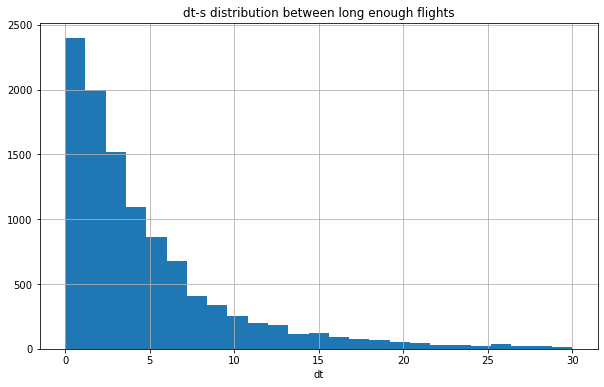

In [7]:
fig, ax = plt.subplots(figsize=(10, 6))

(
    dep_arr_df.query(
        "mvt_type=='DEP' & 6<=hh_num<=22 & (parking_position == parking_position | (taxi_dist>1100 & runway=='32') |  (taxi_dist>1100 & runway=='28') | (taxi_dist>2200 & runway=='16'))"
    )
    .sort_values("first_movement_start")["first_movement_start"]
    .diff()
    .dt.total_seconds()
    / 60
).hist(bins=25, range=(0, 30))
ax.set(title="dt-s distribution between long enough flights", xlabel="dt", ylabel="")

In [8]:
avg_pred_delay_cols = [
    "max_turnaround_minutes_last30T",
    "hh_num",
    "avg_delay_30min",
    "H_count",
    "L_count",
    "L/M_count",
    "M_count",
    "H_count_ratio",
    "L_count_ratio",
    "L/M_count_ratio",
    "M_count_ratio",
    "H_occ",
    "K_occ",
    "B_occ",
    "F_occ",
    "L_occ",
    "J_occ",
    "E_occ",
    "D_occ",
    "C_occ",
    "N_occ",
    "A_occ",
    "M_occ",
    "Y_occ",
    "R_occ",
    "G_occ",
    "Z_occ",
    "P_occ",
    "twy_pca_0",
    "twy_pca_1",
    "twy_pca_2",
    "press",
    "temp",
    "atmap_visibility",
    "atmap_wind",
    "atmap_precipitation",
    "atmap_freezing",
    "atmap_danger",
    "atmap_score",
    "nominal",
    "busy",
    "disrupted",
    "not_nom_arrival_ratio",
    "nb_arr",
    "nb_dep",
    "nb",
    "avg_speed_last30T",
    "avg_speed_last15T",
    "config_EAST",
    "config_NORTH0",
    "config_NORTH1",
    "config_SOUTH",
]

# avg_pred_delay_cols

In [1694]:
with open("../data/processed/main_feature_sets.pkl", "rb") as f:
    main_feature_sets = pickle.load(f)

In [9]:
def chart_avgdel(avgdel, **kwargs):
    return (
        alt.Chart(avgdel.reset_index())
        .mark_line(**kwargs)
        .encode(alt.X("on_runway_time:T"), alt.Y("avg_delay_in30min"))
    )

In [22]:
(avgdel_filled_chart + avgdel_resampled_chart + avgdel_rounded_chart).properties(
    width=800
)

In [10]:
query_incomplete_flights = "mvt_type=='DEP' & (parking_position == parking_position | (taxi_dist>1100 & runway=='32') |  (taxi_dist>1100 & runway=='28') | (taxi_dist>2200 & runway=='16'))"

In [39]:
dep_arr_df.loc[
    dep_arr_df.query(query_incomplete_flights).index, "taxi_completed"
] = True
dep_arr_df["taxi_completed"] = dep_arr_df["taxi_completed"].fillna(False)

In [40]:
dep_arr_df.taxi_completed.describe()

count     35517
unique        2
top       False
freq      23574
Name: taxi_completed, dtype: object

array([[<AxesSubplot:title={'center':'taxi_completed'}>]], dtype=object)

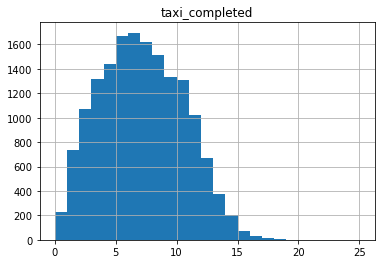

In [41]:
dt_between_deps = (
    dep_arr_df.query("mvt_type=='DEP'")[["on_runway_time", "taxi_completed"]]
    .sort_values("on_runway_time")
    .set_index("on_runway_time")
    .rolling("30T", closed="left")
    .agg({"taxi_completed": "sum"})
)

dt_between_deps.hist(range=(0, 25), bins=25)

In [44]:
dep_arr_df = dep_arr_df.merge(
    dt_between_deps.rename(columns={"taxi_completed": "nb_averaged_values"}),
    left_on="on_runway_time",
    right_index=True,
)

In [46]:
dep_arr_df.head()

flight_id            on_runway_time taxi_holding_time  \
0   GSW4942_15738 2019-10-01 04:00:24+00:00   0 days 00:01:23   
1     EDW200_5718 2019-10-01 04:10:37+00:00   0 days 00:01:18   
10   EDW77D_14374 2019-10-01 04:24:56+00:00   0 days 00:00:00   
12    EDW15T_7910 2019-10-01 04:31:56+00:00   0 days 00:01:03   
16   EDW284K_5650 2019-10-01 04:33:23+00:00   0 days 00:02:41   

   rwy_holding_time total_holding_time  taxi_holding_time_minutes  \
0              None    0 days 00:01:23                   1.383333   
1              None    0 days 00:04:56                   1.300000   
10             None    0 days 00:00:00                   0.000000   
12             None    0 days 00:05:26                   1.050000   
16             None    0 days 00:02:41                   2.683333   

              first_movement callsign registration typecode  ... runway_28  \
0  2019-10-01 03:59:06+00:00  GSW4942       HB-JOG     A319  ...         0   
1  2019-10-01 04:03:36+00:00   EDW200       HB-IHZ     A320  ...         0   
10 2019-10-01 04:21:26+00:00   EDW77D       HB-JLR     A320  ...         0   
12 2019-10-01 04:23:56+00:00   EDW15T       HB-IJV     A320  ...         0   
16 2019-10-01 04:28:57+00:00  EDW284K       HB-IHY     A320  ...         0   

   runway_32 runway_34 config_EAST config_NORTH0  config_NORTH1 config_SOUTH  \
0          0         1           0             0              0            0   
1          1         0           1             0              0            0   
10         1         0           0             0              0            1   
12         1         0           0             0              0            1   
16         1         0           0             0              0            1   

   taxi_holding_time_minutes_cat taxi_completed nb_averaged_values  
0                            0.0          False                NaN  
1                            0.0           True                0.0  
10                           0.0           True                1.0  
12                           0.0           True                2.0  
16                           0.0           True                3.0  

[5 rows x 123 columns]

# Just delay

In [196]:
nday = 22
nmonth = 11

avgdel = (
    dep_arr_df.query(
        f"mvt_type=='DEP' & 6<=hh_num<=22 & on_runway_time.dt.day=={nday} & on_runway_time.dt.month=={nmonth}"
    )
    .sort_values("on_runway_time")
    .set_index("on_runway_time")[["avg_delay_in30min", "nb_averaged_values"]]
)

avgdel_filled = avgdel.fillna(method="bfill")
avgdel_filled_chart = chart_avgdel(avgdel_filled)

avgdel_rounded = avgdel.reset_index()
avgdel_rounded["on_runway_time"] = avgdel_rounded["on_runway_time"].dt.round("10T")

avgdel_rounded_chart = (
    alt.Chart(avgdel_rounded.dropna())
    .mark_square(opacity=0.5, size=75, color="green")
    .encode(x="on_runway_time", y="avg_delay_in30min")
)

avgdel_resampled = (
    avgdel_rounded.drop_duplicates(subset=["on_runway_time"])
    .set_index("on_runway_time")
    .sort_index()
    .resample("2T")
    .interpolate(method="quadratic")
)
avgdel_resampled_chart = chart_avgdel(avgdel_resampled, color="red", opacity=0.7)

avgdel_chart = (
    alt.Chart(avgdel.reset_index())
    .mark_circle(opacity=0.5, size=75)
    .encode(x="on_runway_time", y="avg_delay_in30min", color="nb_averaged_values:O")
)

datachart = avgdel_rounded.groupby("on_runway_time").mean().dropna().reset_index()

avgdel_ind_chart = (
    alt.Chart(datachart)
    .mark_point(color="red")
    .encode(x="on_runway_time", y="avg_delay_in30min")
    .properties(width=800)
)

avgdel_chart + avgdel_rounded_chart + avgdel_ind_chart + avgdel_resampled_chart

alt.LayerChart(...)

In [134]:
avgdel_chart.properties(width=800)

alt.Chart(...)

# all data

In [1438]:
" ".join(feature_df.columns)

'max_turnaround_minutes_last30T hh_num avg_delay_30min H_count L_count L/M_count M_count H_count_ratio L_count_ratio L/M_count_ratio M_count_ratio H_occ K_occ B_occ F_occ L_occ J_occ E_occ D_occ C_occ N_occ A_occ M_occ Y_occ R_occ G_occ Z_occ P_occ twy_pca_0 twy_pca_1 twy_pca_2 press temp atmap_visibility atmap_wind atmap_precipitation atmap_freezing atmap_danger atmap_score nominal busy disrupted not_nom_arrival_ratio nb_arr nb_dep nb avg_speed_last30T avg_speed_last15T config_EAST config_NORTH0 config_NORTH1 config_SOUTH on_runway_time'

In [1574]:
feature_df = dep_arr_df.query("mvt_type=='DEP'")[
    avg_pred_delay_cols + ["on_runway_time"]
]


avgdel_rounded = feature_df
avgdel_rounded["on_runway_time"] = avgdel_rounded["on_runway_time"].dt.round("10T")
avgdel_rounded = avgdel_rounded.groupby("on_runway_time").mean().reset_index()
feature_df_resampled = (
    avgdel_rounded.set_index("on_runway_time")  # .drop("avg_delay_30min", axis=1)
    .sort_index()
    .resample("2T")
    .interpolate(method="quadratic")  # , limit_direction="backward" order=2
    .reset_index()
)

In [1575]:
feature_df_resampled.loc[
    (feature_df_resampled["on_runway_time"].dt.hour < 6)
    | (feature_df_resampled["on_runway_time"].dt.hour > 22),
    "avg_delay_30min",
] = 0

In [1576]:
cols = ["on_runway_time", "avg_delay_30min"]
a = feature_df_resampled[cols].query(
    "on_runway_time.dt.day == 19 & on_runway_time.dt.month == 10"
)
b = feature_df[cols].query(
    "on_runway_time.dt.day == 19 & on_runway_time.dt.month == 10"
)

resampled_chart = alt.Chart(a).mark_line().encode(x="on_runway_time", y=f"{cols[1]}")
orig_chart = (
    alt.Chart(b)
    .mark_circle(color="red", opacity=0.5)
    .encode(x="on_runway_time", y=f"{cols[1]}")
)
resampled_chart + orig_chart

alt.LayerChart(...)

In [1577]:
cols = ["on_runway_time", "avg_delay_30min"]
a = feature_df_resampled[cols].query(
    "on_runway_time.dt.day == 14 & on_runway_time.dt.month == 11"
)
b = feature_df[cols].query(
    "on_runway_time.dt.day == 14 & on_runway_time.dt.month == 11"
)

resampled_chart = alt.Chart(a).mark_line().encode(x="on_runway_time", y=f"{cols[1]}")
orig_chart = (
    alt.Chart(b)
    .mark_circle(color="red", opacity=0.5)
    .encode(x="on_runway_time", y=f"{cols[1]}")
)
resampled_chart + orig_chart

alt.LayerChart(...)

#### TODO: pour chaqye jour lors de la creation des datasets input, supprimer la partie avant (resp apres) le premier (resp le dernier) point avec un avg_delay

In [435]:
avgdel_rounded.duplicated(subset=["on_runway_time"]).sum()

0

In [1629]:
feature_df_resampled = feature_df_resampled.dropna()

feature_df_resampled.loc[
    feature_df_resampled.avg_delay_30min < 0, "avg_delay_30min"
] = 0
feature_df_resampled.loc[
    feature_df_resampled.avg_delay_30min < 0, "avg_delay_in30min"
] = 0

In [14]:
nday = 14
nmonth = 11

In [15]:
feature_df_resampled_sample = feature_df_resampled.query(
    f"(on_runway_time.dt.day=={nday} | on_runway_time.dt.day=={nday+1}) & on_runway_time.dt.month=={nmonth}"
)

In [16]:
feature_df_resampled_sample.reset_index().avg_delay_30min

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1435    0.0
1436    0.0
1437    0.0
1438    0.0
1439    0.0
Name: avg_delay_30min, Length: 1440, dtype: float64

In [17]:
feature_df_resampled_sample_avgdelay_chart = (
    alt.Chart(
        feature_df_resampled_sample.reset_index()[["on_runway_time", "avg_delay_30min"]]
    )
    .mark_line()
    .encode(x="on_runway_time", y="avg_delay_30min")
)

In [18]:
feature_df_avgdelay_chart = (
    alt.Chart(
        feature_df.query(
            f"(on_runway_time.dt.day=={nday} | on_runway_time.dt.day=={nday+1}) & on_runway_time.dt.month=={nmonth}"
        )[["on_runway_time", "avg_delay_30min"]]
    )
    .mark_point(color="green")
    .encode(
        x="on_runway_time",
        y="avg_delay_30min",
        tooltip=["utchoursminutes(on_runway_time)"],
    )
)

In [19]:
(feature_df_avgdelay_chart + feature_df_resampled_sample_avgdelay_chart).properties(
    width=800
)

alt.LayerChart(...)

In [112]:
feature_df_maxturnaround_chart = (
    alt.Chart(
        feature_df.query(
            f"6<=hh_num<=22 & on_runway_time.dt.day=={nday} & on_runway_time.dt.month=={nmonth}"
        )[["on_runway_time", "max_turnaround_minutes_last30T"]]
    )
    .mark_point(color="orange")
    .encode(x="on_runway_time", y="max_turnaround_minutes_last30T")
)

In [114]:
feature_df_resampled_sample_maxturnaround_chart = (
    alt.Chart(
        feature_df_resampled_sample.reset_index()[
            ["on_runway_time", "max_turnaround_minutes_last30T"]
        ]
    )
    .mark_line()
    .encode(x="on_runway_time", y="max_turnaround_minutes_last30T")
)

In [117]:
(
    feature_df_resampled_sample_maxturnaround_chart + feature_df_maxturnaround_chart
).properties(width=800)

alt.LayerChart(...)

In [118]:
feature_df_config_chart = (
    alt.Chart(
        feature_df.query(
            f"6<=hh_num<=22 & on_runway_time.dt.day=={nday} & on_runway_time.dt.month=={nmonth}"
        )[["on_runway_time", "config_NORTH0"]]
    )
    .mark_point(color="purple")
    .encode(x="on_runway_time", y="config_NORTH0")
)

In [119]:
feature_df_resampled_sample_config_chart = (
    alt.Chart(
        feature_df_resampled_sample.reset_index()[["on_runway_time", "config_NORTH0"]]
    )
    .mark_line()
    .encode(x="on_runway_time", y="config_NORTH0")
)

In [120]:
(feature_df_config_chart + feature_df_resampled_sample_config_chart).properties(
    width=800
)

alt.LayerChart(...)

# Trying with RF

In [367]:
temp_df = feature_df_resampled.query(
    "6<=on_runway_time.dt.hour<22"
)  # because we predict from 6:30 to 22:00
target_df = feature_df_resampled.reset_index()[["avg_delay_30min", "on_runway_time"]]
target_df["on_runway_time"] = target_df["on_runway_time"] - pd.Timedelta("30T")
target_df = target_df.rename(columns={"avg_delay_30min": "avg_delay_in30min"})
temp_df = temp_df.merge(target_df, on="on_runway_time", how="left")

temp_df["mvt_type"] = "DEP"

Results for Random Forest on the following features :
max_turnaround_minutes_last30T hh_num avg_delay_30min H_count L_count L/M_count M_count H_count_ratio L_count_ratio L/M_count_ratio M_count_ratio H_occ K_occ B_occ F_occ L_occ J_occ E_occ D_occ C_occ N_occ A_occ M_occ Y_occ R_occ G_occ Z_occ P_occ twy_pca_0 twy_pca_1 twy_pca_2 press temp atmap_visibility atmap_wind atmap_precipitation atmap_freezing atmap_danger atmap_score nominal busy disrupted not_nom_arrival_ratio nb_arr nb_dep nb avg_speed_last30T avg_speed_last15T config_EAST config_NORTH0 config_NORTH1 config_SOUTH
Target var : avg_delay_in30min
Selecting the subset with following query : 
(on_runway_time.dt.day!=17 | on_runway_time.dt.month!=11)
mae=	0.6187071720946057
mse=	0.9632009083575912
rmse=	0.9814279944843591
acc1min=82.27489828409695
acc3min=98.6555811073766
acc5min=99.77003361047232
R2=	0.8414812531965095
n_sample training : 22608
n_sample test : 5653
n_sample_tot=28261



alt.Chart(...)

alt.LayerChart(...)

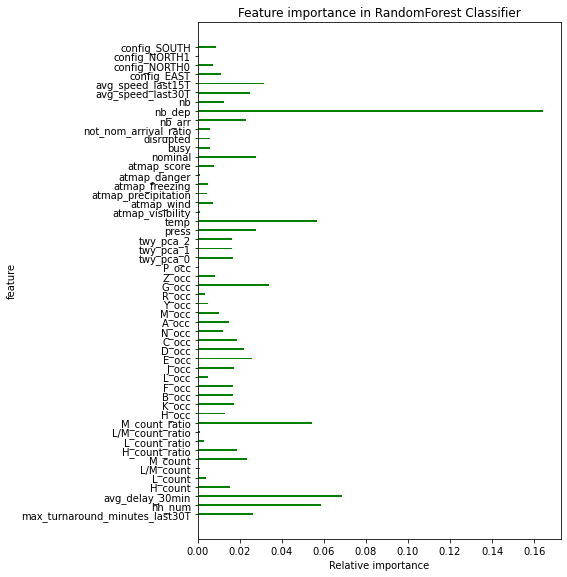

<Figure size 360x576 with 0 Axes>

In [368]:
nday = 17
nmonth = 11

base_dir = "../prediction_results/"
target_var = "avg_delay_in30min"
test_name = f"TEMP_interpolated/"

res, labels_test, predicted, clf = train_rf(
    temp_df,
    avg_pred_delay_cols,
    target_var,
    query=f"(on_runway_time.dt.day!={nday} | on_runway_time.dt.month!={nmonth})",
    dirname=base_dir + test_name,
    dropna=False,
)

##### Displaying prediction over one day

query_incomplete_flights = "mvt_type=='DEP' & (parking_position == parking_position | (taxi_dist>1100 & runway=='32') |  (taxi_dist>1100 & runway=='28') | (taxi_dist>2200 & runway=='16'))"

dep_arr_df_ = dep_arr_df.sort_values("on_runway_time")
dep_arr_df_[target_var] = dep_arr_df_[target_var].fillna(method="bfill")

dep_arr_df_ = dep_arr_df_.query(query_incomplete_flights)

feature_columns = avg_pred_delay_cols
target_column = target_var

flight_df = temp_df.query(
    f"mvt_type=='DEP' & on_runway_time.dt.day=={nday} & on_runway_time.dt.month=={nmonth}"
)
data_df = flight_df[avg_pred_delay_cols + [target_column, "on_runway_time"]]

data_df = data_df.sort_values("on_runway_time").fillna(method="backfill").dropna()
times = data_df["on_runway_time"]
data_df = data_df.drop(["on_runway_time"], axis=1)
input_df = data_df[feature_columns]
target_df = data_df[[target_column]]

predicted = clf.predict(input_df)

daily_compare_res_df = pd.DataFrame(
    {
        "times": times,
        "truth": target_df.values.reshape((-1,)),
        "predicted": predicted.reshape((-1,)),
    }
)

truth_chart = (
    alt.Chart(daily_compare_res_df)
    .mark_line(color="red")
    .encode(x="times:T", y="truth")
)
predicted_chart = (
    alt.Chart(daily_compare_res_df)
    .mark_line(color="blue")
    .encode(x="times:T", y="predicted")
)
truth_chart + predicted_chart

# Sequences creation

In [1630]:
import random

In [1631]:
dates = list(pd.date_range(start="2019-10-01", end="2019-11-30", tz="utc"))
nday_test = 11
test_dates = random.sample(dates, nday_test)
test_dates.append(pd.Timestamp("2019-10-19", tz="utc"))

In [1632]:
test_dates

[Timestamp('2019-10-16 00:00:00+0000', tz='UTC', freq='D'),
 Timestamp('2019-10-11 00:00:00+0000', tz='UTC', freq='D'),
 Timestamp('2019-10-30 00:00:00+0000', tz='UTC', freq='D'),
 Timestamp('2019-10-25 00:00:00+0000', tz='UTC', freq='D'),
 Timestamp('2019-11-01 00:00:00+0000', tz='UTC', freq='D'),
 Timestamp('2019-11-23 00:00:00+0000', tz='UTC', freq='D'),
 Timestamp('2019-11-28 00:00:00+0000', tz='UTC', freq='D'),
 Timestamp('2019-10-23 00:00:00+0000', tz='UTC', freq='D'),
 Timestamp('2019-11-29 00:00:00+0000', tz='UTC', freq='D'),
 Timestamp('2019-10-14 00:00:00+0000', tz='UTC', freq='D'),
 Timestamp('2019-11-22 00:00:00+0000', tz='UTC', freq='D'),
 Timestamp('2019-10-19 00:00:00+0000', tz='UTC')]

In [1637]:
temp_df = feature_df_resampled.drop("avg_delay_in30min", axis=1)
target_df = feature_df_resampled[["avg_delay_30min", "on_runway_time"]]
target_df["on_runway_time"] = target_df["on_runway_time"] - pd.Timedelta("30T")
target_df = target_df.rename(columns={"avg_delay_30min": "avg_delay_in30min"})
temp_df = temp_df.merge(target_df, on="on_runway_time", how="left")

temp_df["mvt_type"] = "DEP"

/tmp/ipykernel_190349/1295330449.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df["on_runway_time"] = target_df["on_runway_time"] - pd.Timedelta("30T")


In [1639]:
temp_df["avg_delay_diff"] = temp_df["avg_delay_in30min"] - temp_df["avg_delay_30min"]

In [1640]:
temp_df["avg_delay_diff"].describe()

count    42901.000000
mean         0.000035
std          2.652295
min        -29.725463
25%         -0.769425
50%          0.000000
75%          1.000880
max         28.820682
Name: avg_delay_diff, dtype: float64

In [1641]:
assert (
    temp_df.query("avg_delay_in30min<0").shape[0]
    == 0 & temp_df.query("avg_delay_30min<0").shape[0]
    == 0
)

In [1693]:
" ".join(temp_df.columns), len(temp_df.columns)

('on_runway_time max_turnaround_minutes_last30T hh_num avg_delay_30min H_count L_count L/M_count M_count H_count_ratio L_count_ratio L/M_count_ratio M_count_ratio H_occ K_occ B_occ F_occ L_occ J_occ E_occ D_occ C_occ N_occ A_occ M_occ Y_occ R_occ G_occ Z_occ P_occ twy_pca_0 twy_pca_1 twy_pca_2 press temp atmap_visibility atmap_wind atmap_precipitation atmap_freezing atmap_danger atmap_score nominal busy disrupted not_nom_arrival_ratio nb_arr nb_dep nb avg_speed_last30T avg_speed_last15T config_EAST config_NORTH0 config_NORTH1 config_SOUTH avg_delay_in30min mvt_type avg_delay_diff',
 56)

In [1695]:
" ".join(main_feature_sets["sfs_forward_20"])

'max_turnaround_minutes_last30T hh_num H_count L_count L/M_count M_count L_count_ratio H_occ J_occ M_occ Z_occ press temp atmap_score nominal busy disrupted not_nom_arrival_ratio config_EAST config_NORTH0'

In [1743]:
cols_to_drop_later = [
    "on_runway_time",
    "avg_delay_in30min",
    "mvt_type",
    "avg_delay_diff",
    "avg_delay_30min",
    # "day",
]

In [1836]:
cols_to_select = list(
    temp_df.columns  # cols_to_drop_later + main_feature_sets["sfs_forward_20"]  # temp_df.columns
)  # ["on_runway_time", "avg_delay_in30min", "avg_delay_30min", "day", "avg_delay_diff"]

In [1837]:
temp_df_train = temp_df.query(
    "on_runway_time.dt.floor('1d') not in @test_dates"
).assign(  # dummy test to be changed if attempts want to be made on other days
    day=lambda x: x.on_runway_time.dt.floor("1d")
)[
    cols_to_select + ["day"]
]

temp_df_test = temp_df.query(
    "on_runway_time.dt.floor('1d') in @test_dates"
).assign(  # dummy test to be changed if attempts want to be made on other days
    day=lambda x: x.on_runway_time.dt.floor("1d")
)[
    cols_to_select + ["day"]
]

In [1838]:
sc = StandardScaler()

In [1839]:
sc = sc.fit(
    temp_df_train.drop(
        [
            "on_runway_time",
            "avg_delay_in30min",
            "mvt_type",
            "avg_delay_diff",
            "day",
        ],
        axis=1,
    )
)

In [1840]:
from sklearn.preprocessing import MinMaxScaler

In [1841]:
sc_preds = MinMaxScaler()

In [1842]:
sc_preds = sc_preds.fit(temp_df_train.avg_delay_diff.values.reshape(-1, 1))

In [1843]:
%%time
tw_size = "2h"  # => 60min === 30 observations ==>
downsample_dt = "2T"
n_obs_window = pd.Timedelta(tw_size) / pd.Timedelta(downsample_dt)

print(n_obs_window)

input_seqs_train = []
target_out_train = []
input_seqs_test = []
target_out_test = []
time_seqs_train = []
time_seqs_test = []

i=0

for name, day_win in temp_df_train.groupby('day'):
    true_times=feature_df.query(f"on_runway_time.dt.floor('1d')=='{name}'").on_runway_time
    min_time_day = true_times.min()
    max_time_day = true_times.max()
    day_win = day_win.query(f"6<=on_runway_time.dt.hour<22") 
    # day_win = day_win.query(f"'{min_time_day}'<=on_runway_time<'{max_time_day}'") 
    day_win = day_win.set_index("on_runway_time")
    for win in day_win.rolling(tw_size):
        if win.shape[0] == n_obs_window:
            input_seq = win.drop(
                ["avg_delay_in30min",
                     "mvt_type", 
                     "day",
                    "avg_delay_diff"], axis=1
            ).values.tolist()
            input_seq = sc.transform(input_seq)
            to_pred = win.iloc[-1].avg_delay_diff
            if to_pred == to_pred:
                #to_pred = sc_preds.transform([[to_pred]])[0,0]
                input_seqs_train.append(input_seq)
                target_out_train.append(to_pred)
                time_seqs_train.append(win.iloc[-1].name)
 #  i+=1
 #  print(name)
 #  if i>5:
 #      break
            
for name, day_win in temp_df_test.groupby('day'):
    true_times=feature_df.query(f"on_runway_time.dt.floor('1d')=='{name}'").on_runway_time
    min_time_day = true_times.min()
    max_time_day = true_times.max()
    day_win = day_win.query(f"6<=on_runway_time.dt.hour<22")
    # day_win = day_win.query(f"'{min_time_day}'<=on_runway_time<'{max_time_day}'")
    day_win = day_win.set_index("on_runway_time")
    for win in day_win.rolling(tw_size):
        if win.shape[0] == n_obs_window:
            input_seq = win.drop(
                ["avg_delay_in30min",
                     "mvt_type",
                     "day",
                    "avg_delay_diff"], axis=1
            ).values.tolist()
            input_seq = sc.transform(input_seq)
            to_pred = win.iloc[-1].avg_delay_diff
            if to_pred == to_pred:
                #to_pred = sc_preds.transform([[to_pred]])[0,0]
                input_seqs_test.append(input_seq)
                target_out_test.append(to_pred)
                time_seqs_test.append(win.iloc[-1].name)

60.0
CPU times: user 36.1 s, sys: 0 ns, total: 36.1 s
Wall time: 36.1 s


In [1848]:
input_seqs_test_ = np.array(input_seqs_test)
target_out_test_ = np.array(target_out_test)
input_seqs_train_ = np.array(input_seqs_train)
target_out_train_ = np.array(target_out_train)
time_seqs_train = np.array(time_seqs_train)
time_seqs_test = np.array(time_seqs_test)

In [1849]:
target_out_train_

array([-3.6477275 , -3.82728956, -3.9968429 , ...,  2.49589142,
        2.64542592,  2.76600716])

In [1850]:
time_seqs_test.shape, input_seqs_test_.shape

((5008,), (5008, 60, 52))

In [1851]:
input_seqs_train_.shape, target_out_train_.shape

((20193, 60, 52), (20193,))

In [1852]:
# TO KNOW IF THERE IS NAN VALUES
def has_nan(npa):
    array_sum = np.sum(npa)
    return np.isnan(array_sum)


has_nan(input_seqs_train_)

False

In [1853]:
input_seqs_train_.shape[1], input_seqs_train_.shape[2]

(60, 52)

In [1854]:
from keras.layers.experimental import preprocessing
from keras import Sequential
from keras.regularizers import l1, l2, L1L2

In [1855]:
from keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor="val_loss", patience=4, min_delta=0.08)

In [1856]:
from keras.layers import LSTM, GRU, Dense
from keras.optimizers import Adam

"""
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(data_train))
print(normalizer.mean.numpy())
"""
# optimizer
opt = Adam(learning_rate=1e-3)
# design network
model = Sequential()
# model.add(normalizer)
model.add(
    GRU(
        128,
        input_shape=(input_seqs_train_.shape[1], input_seqs_train_.shape[2]),
        return_sequences=True,
        kernel_regularizer=L1L2(0.01, 0.01),
        # dropout=0.5,
    )
)
# model.add(LSTM(64, return_sequences=True))
model.add(
    GRU(128, return_sequences=True, kernel_regularizer=L1L2(0.01, 0.01))
)  # kernel_regularizer=l1(0.01))
# model.add(LSTM(256, return_sequences=True))
# model.add(LSTM(128, return_sequences=True, dropout=0.3))
model.add(GRU(128, kernel_regularizer=L1L2(0.01, 0.01)))
model.add(Dense(1))
model.compile(loss="mse", optimizer=opt)
# fit network

In [1857]:
print(model.summary())

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_31 (GRU)                 (None, 60, 128)           69888     
_________________________________________________________________
gru_32 (GRU)                 (None, 60, 128)           99072     
_________________________________________________________________
gru_33 (GRU)                 (None, 128)               99072     
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 129       
Total params: 268,161
Trainable params: 268,161
Non-trainable params: 0
_________________________________________________________________
None


In [1858]:
history = model.fit(
    input_seqs_train_,
    target_out_train_,
    epochs=50,
    batch_size=128,
    validation_data=(input_seqs_test_, target_out_test_),
    verbose=1,
    shuffle=False,
    callbacks=[callback],
)

Epoch 1/50
158/158 [==============================] - 894s 5s/step - loss: 48.3439 - val_loss: 14.0310
Epoch 2/50
158/158 [==============================] - 127s 802ms/step - loss: 11.9326 - val_loss: 9.3681
Epoch 3/50
158/158 [==============================] - 125s 792ms/step - loss: 8.4603 - val_loss: 8.0850
Epoch 4/50
158/158 [==============================] - 131s 833ms/step - loss: 7.4630 - val_loss: 7.6083
Epoch 5/50
158/158 [==============================] - 117s 741ms/step - loss: 7.0144 - val_loss: 7.2868
Epoch 6/50
158/158 [==============================] - 136s 860ms/step - loss: 6.9516 - val_loss: 7.2925
Epoch 7/50
158/158 [==============================] - 136s 863ms/step - loss: 6.6031 - val_loss: 6.9854
Epoch 8/50
158/158 [==============================] - 150s 952ms/step - loss: 6.4607 - val_loss: 6.9074
Epoch 9/50
158/158 [==============================] - 129s 814ms/step - loss: 6.3323 - val_loss: 6.8164
Epoch 10/50
158/158 [==============================] - 123s 777m

In [1859]:
model.save("../prediction_results/_GRUs/018_BIS/")

In [1860]:
with open("../prediction_results/_GRUs/018_BIS/history.pkl", "wb") as file_pi:
    pickle.dump(history.history, file_pi)

In [1861]:
import matplotlib.pyplot as plt

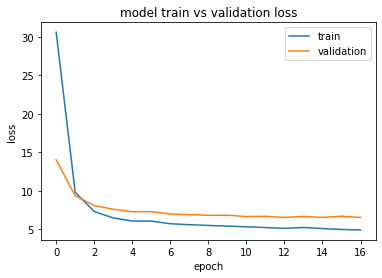

In [1862]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model train vs validation loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper right")
plt.show()

In [1863]:
from keras.models import load_model

In [1864]:
result_training = model.evaluate(input_seqs_test_, target_out_test_)

157/157 [==============================] - 20s 124ms/step - loss: 6.5369


In [1865]:
predicted = model.predict(input_seqs_test_)

In [1866]:
predicted = predicted  # sc_preds.inverse_transform(predicted)
truth = target_out_test_.reshape(
    -1, 1
)  # sc_preds.inverse_transform(target_out_test_.reshape(-1, 1))

data_chart = pd.DataFrame(
    {
        "true": truth.reshape((1, -1))[0],
        "pred": predicted.reshape((1, -1))[0],
    }
)

<AxesSubplot:>

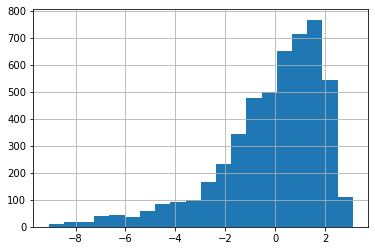

In [1867]:
data_chart.pred.hist(bins=20)

<AxesSubplot:>

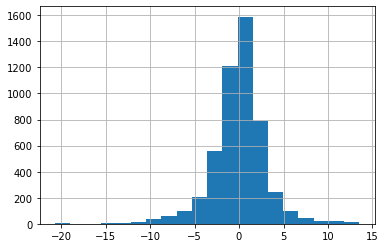

In [1868]:
data_chart.true.hist(bins=20)

In [1869]:
data_chart["times"] = time_seqs_test

In [1870]:
predVStrue_chart = alt.Chart(data_chart).mark_circle(opacity=0.5).encode(
    x="true", y="pred", tooltip="times"
) + alt.Chart(
    pd.DataFrame({"x": np.linspace(0, 15, 10), "y": np.linspace(0, 15, 10)})
).mark_line(
    color="black"
).encode(
    x="x", y="y"
)
display(predVStrue_chart)

alt.LayerChart(...)

In [1871]:
predVStruth_avgdelay_df = data_chart.merge(
    temp_df_test[["avg_delay_in30min", "avg_delay_30min", "on_runway_time"]],
    how="left",
    left_on="times",
    right_on="on_runway_time",
)

In [1872]:
predVStruth_avgdelay_df["predicted_avg_in30min"] = (
    predVStruth_avgdelay_df["avg_delay_30min"] + predVStruth_avgdelay_df["pred"]
)

In [1873]:
results(
    predVStruth_avgdelay_df.avg_delay_in30min,
    predVStruth_avgdelay_df.predicted_avg_in30min,
)

ResMetrics(mae=1.6281797051914306, mse=5.744033957054795, rmse=2.3966714328532386, acc1min=44.04952076677316, acc3min=87.02076677316293, acc5min=95.56709265175719, r2=0.1312859588718034)

# one One day of data 

In [1874]:
!ls ../prediction_results/_GRUs/

016_addingl1_anddroppout     018_BIS			  019_onlysfsf
017_l1onBIASinsteadofKERNEL  018_moremeaningfulavgdelays


In [1875]:
day = pd.Timestamp("2019-10-19", tz="utc")  # test_dates[4]
day  #

Timestamp('2019-10-19 00:00:00+0000', tz='UTC')

In [1876]:
def plot_one_day(day, times, trainseqs, targets):
    s = pd.Series(times)
    times = s.loc[s.where((day <= s) & (s < (day + pd.Timedelta("1d")))).notna()]
    idx = times.index
    dayseq = np.take(trainseqs, idx, axis=0)
    daytruth = np.take(targets, idx, axis=0)
    return times, dayseq, daytruth

In [1877]:
times, topred, truth = plot_one_day(
    day, time_seqs_test, input_seqs_test_, target_out_test_
)

In [1878]:
predicted = model.predict(topred)

In [1879]:
daily_compare_res_df = pd.DataFrame(
    {
        "times": times,
        "truth": truth.reshape((-1,)),
        "predicted": predicted.reshape((-1,)),
    }
)

truth_chart = (
    alt.Chart(daily_compare_res_df)
    .mark_line(color="red")
    .encode(x="utchoursminutes(times):T", y="truth")
)
predicted_chart = (
    alt.Chart(daily_compare_res_df)
    .mark_line(color="qsd")
    .encode(x="utchoursminutes(times):T", y="predicted")
)
truth_chart + predicted_chart

alt.LayerChart(...)

In [1880]:
daily_compare_AVGDELAYS_res_df = daily_compare_res_df.merge(
    temp_df_test, how="left", left_on="times", right_on="on_runway_time"
)

In [1881]:
daily_compare_AVGDELAYS_res_df["predicted_avg_in30min"] = (
    daily_compare_AVGDELAYS_res_df["avg_delay_30min"]
    + daily_compare_AVGDELAYS_res_df["predicted"]
)

In [1882]:
daily_compare_AVGDELAYS_res_df.query("7<=times.dt.hour<=20").rename(
    columns={
        "avg_delay_in30min": "truth",
        "predicted_avg_in30min": "predicted",
    }
).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391 entries, 0 to 390
Data columns (total 61 columns):
 #   Column                          Non-Null Count  Dtype              
---  ------                          --------------  -----              
 0   times                           391 non-null    datetime64[ns, UTC]
 1   truth                           391 non-null    float64            
 2   predicted                       391 non-null    float32            
 3   on_runway_time                  391 non-null    datetime64[ns, UTC]
 4   max_turnaround_minutes_last30T  391 non-null    float64            
 5   hh_num                          391 non-null    float64            
 6   avg_delay_30min                 391 non-null    float64            
 7   H_count                         391 non-null    float64            
 8   L_count                         391 non-null    float64            
 9   L/M_count                       391 non-null    float64            
 10  M_count       

In [1883]:
truth_vs_pred_chart = (
    alt.Chart(
        daily_compare_AVGDELAYS_res_df.query("7<=times.dt.hour<=20").rename(
            columns={
                "avg_delay_in30min": "truth",
                "predicted_avg_in30min": "predicted",
            }
        )[["truth", "predicted", "times"]]
    )
    .transform_fold(["truth", "predicted"])
    .mark_line()
    .encode(
        x=alt.X("utchoursminutes(times):T", title="Time"),
        y=alt.Y("value:Q", title="Average additional TXOT"),
        color="key:N",
    )
)

truth_vs_pred_chart

TypeError: ufunc 'isinf' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

alt.Chart(...)

In [1884]:
.configure_axis(
        labelFont="Ubuntu",
        titleFont="Fira Sans",
        labelFontSize=15,
        titleFontSize=16,
    )
    .configure_legend(
        orient="bottom", labelFontSize=14, titleFontSize=14, labelFont="Ubuntu"
    )
    .configure_view(stroke=None)
    .configure_title(font="Fira Sans", fontSize=18, anchor="start", dy=-10)
    .configure_header(
        labelFont="Ubuntu",
        labelFontSize=18,
        labelOrient="top",
    )
    .properties(width=800)

SyntaxError: invalid syntax (3331685672.py, line 1)

ERROR:root:Cannot parse: 1:1: .configure_axis(
Traceback (most recent call last):
  File "/home/service/miniconda3/envs/traffic/lib/python3.9/site-packages/lab_black.py", line 218, in format_cell
    formatted_code = _format_code(cell)
  File "/home/service/miniconda3/envs/traffic/lib/python3.9/site-packages/lab_black.py", line 29, in _format_code
    return format_str(src_contents=code, mode=FileMode())
  File "/home/service/miniconda3/envs/traffic/lib/python3.9/site-packages/black/__init__.py", line 819, in format_str
    src_node = lib2to3_parse(src_contents.lstrip(), mode.target_versions)
  File "/home/service/miniconda3/envs/traffic/lib/python3.9/site-packages/black/parsing.py", line 96, in lib2to3_parse
    raise exc from None
black.parsing.InvalidInput: Cannot parse: 1:1: .configure_axis(


### With a train day (to del)

In [ ]:
l_train_dates = [x for x in dates if x not in test_dates]

In [ ]:
times, topred, truth = plot_one_day(
    l_train_dates[0], time_seqs_train, input_seqs_train_, target_out_train_
)

In [ ]:
predicted = model.predict(topred)

In [ ]:
daily_compare_res_df = pd.DataFrame(
    {
        "times": times,
        "truth": truth.reshape((-1,)),
        "predicted": predicted.reshape((-1,)),
    }
)

truth_chart = (
    alt.Chart(daily_compare_res_df)
    .mark_line(color="red")
    .encode(x="times:T", y="truth")
)
predicted_chart = (
    alt.Chart(daily_compare_res_df)
    .mark_line(color="blue")
    .encode(x="times:T", y="predicted")
)
truth_chart + predicted_chart

In [ ]:
daily_compare_AVGDELAYS_res_df = daily_compare_res_df.merge(
    temp_df_train, how="left", left_on="times", right_on="on_runway_time"
)

In [ ]:
daily_compare_AVGDELAYS_res_df["predicted_avg_in30min"] = (
    daily_compare_AVGDELAYS_res_df["avg_delay_30min"]
    + daily_compare_AVGDELAYS_res_df["predicted"]
)

In [ ]:
daily_compare_AVGDELAYS_res_df
truth_vs_pred_chart = (
    alt.Chart(daily_compare_AVGDELAYS_res_df)
    .transform_fold(["avg_delay_in30min", "predicted_avg_in30min"])
    .mark_line()
    .encode(x="times:T", y="value:Q", color="key:N")
)
truth_vs_pred_chart

### Daily squared error

In [1686]:
predVStruth_avgdelay_df["diff_squared"] = (
    predVStruth_avgdelay_df["avg_delay_in30min"]
    - predVStruth_avgdelay_df["predicted_avg_in30min"]
) ** 2

In [1687]:
alt.Chart(predVStruth_avgdelay_df).mark_line().encode(
    x="utchoursminutes(times)", y="mean(diff_squared)"
)

alt.Chart(...)

In [1688]:
alt.Chart(predVStruth_avgdelay_df).mark_line().encode(
    x="utchours(times)", y="mean(diff_squared)"
)

alt.Chart(...)

# Trying with LR finder

In [970]:
from keras.callbacks import Callback
import keras.backend as K
import numpy as np
import matplotlib.pyplot as plt


class LRFinder(Callback):
    def __init__(
        self,
        min_lr,
        max_lr,
        mom=0.9,
        stop_multiplier=None,
        reload_weights=True,
        batches_lr_update=5,
    ):
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.mom = mom
        self.reload_weights = reload_weights
        self.batches_lr_update = batches_lr_update
        if stop_multiplier is None:
            self.stop_multiplier = -20 * self.mom / 3 + 10  # 4 if mom=0.9
            # 10 if mom=0
        else:
            self.stop_multiplier = stop_multiplier

    def on_train_begin(self, logs={}):
        p = self.params
        try:
            n_iterations = p["epochs"] * p["samples"] // p["batch_size"]
        except:
            n_iterations = p["steps"] * p["epochs"]

        self.learning_rates = np.geomspace(
            self.min_lr, self.max_lr, num=n_iterations // self.batches_lr_update + 1
        )
        self.losses = []
        self.iteration = 0
        self.best_loss = 0
        if self.reload_weights:
            self.model.save_weights("tmp.hdf5")

    def on_batch_end(self, batch, logs={}):
        loss = logs.get("loss")

        if self.iteration != 0:  # Make loss smoother using momentum
            loss = self.losses[-1] * self.mom + loss * (1 - self.mom)

        if self.iteration == 0 or loss < self.best_loss:
            self.best_loss = loss

        if (
            self.iteration % self.batches_lr_update == 0
        ):  # Evaluate each lr over 5 epochs

            if self.reload_weights:
                self.model.load_weights("tmp.hdf5")

            lr = self.learning_rates[self.iteration // self.batches_lr_update]
            K.set_value(self.model.optimizer.lr, lr)

            self.losses.append(loss)

        if loss > self.best_loss * self.stop_multiplier:  # Stop criteria
            self.model.stop_training = True

        self.iteration += 1

    def on_train_end(self, logs=None):
        if self.reload_weights:
            self.model.load_weights("tmp.hdf5")

        plt.figure(figsize=(12, 6))
        plt.plot(self.learning_rates[: len(self.losses)], self.losses)
        plt.xlabel("Learning Rate")
        plt.ylabel("Loss")
        plt.xscale("log")
        plt.show()

Epoch 1/2
161/161 [==============================] - 95s 527ms/step - loss: 4.3789
Epoch 2/2
161/161 [==============================] - 99s 616ms/step - loss: 6.1242


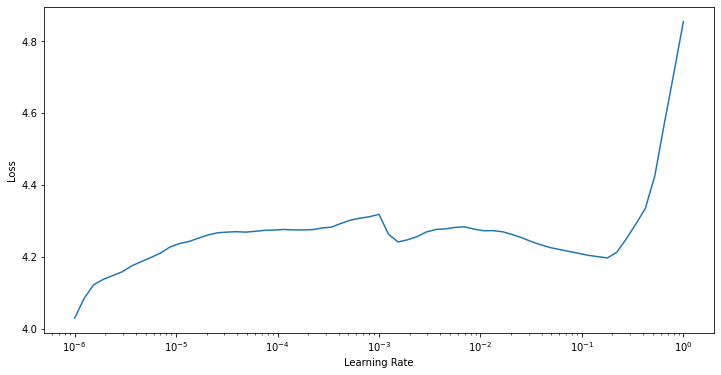

In [971]:
lr_finder = LRFinder(min_lr=1e-6, max_lr=1)

model.fit(
    input_seqs_train_,
    target_out_train_,
    batch_size=128,
    callbacks=[lr_finder],
    epochs=2,
)

# Sequences creation SEQ2SEQ

In [1631]:
dates = list(pd.date_range(start="2019-10-01", end="2019-11-30", tz="utc"))
nday_test = 11
test_dates = random.sample(dates, nday_test)
test_dates.append(pd.Timestamp("2019-10-19", tz="utc"))

In [1637]:
temp_df = feature_df_resampled.drop("avg_delay_in30min", axis=1)
target_df = feature_df_resampled[["avg_delay_30min", "on_runway_time"]]
target_df["on_runway_time"] = target_df["on_runway_time"] - pd.Timedelta("30T")
target_df = target_df.rename(columns={"avg_delay_30min": "avg_delay_in30min"})
temp_df = temp_df.merge(target_df, on="on_runway_time", how="left")

temp_df["mvt_type"] = "DEP"

/tmp/ipykernel_190349/1295330449.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df["on_runway_time"] = target_df["on_runway_time"] - pd.Timedelta("30T")


In [1639]:
temp_df["avg_delay_diff"] = temp_df["avg_delay_in30min"] - temp_df["avg_delay_30min"]

In [1640]:
temp_df["avg_delay_diff"].describe()

count    42901.000000
mean         0.000035
std          2.652295
min        -29.725463
25%         -0.769425
50%          0.000000
75%          1.000880
max         28.820682
Name: avg_delay_diff, dtype: float64

In [1641]:
assert (
    temp_df.query("avg_delay_in30min<0").shape[0]
    == 0 & temp_df.query("avg_delay_30min<0").shape[0]
    == 0
)

In [1693]:
" ".join(temp_df.columns), len(temp_df.columns)

('on_runway_time max_turnaround_minutes_last30T hh_num avg_delay_30min H_count L_count L/M_count M_count H_count_ratio L_count_ratio L/M_count_ratio M_count_ratio H_occ K_occ B_occ F_occ L_occ J_occ E_occ D_occ C_occ N_occ A_occ M_occ Y_occ R_occ G_occ Z_occ P_occ twy_pca_0 twy_pca_1 twy_pca_2 press temp atmap_visibility atmap_wind atmap_precipitation atmap_freezing atmap_danger atmap_score nominal busy disrupted not_nom_arrival_ratio nb_arr nb_dep nb avg_speed_last30T avg_speed_last15T config_EAST config_NORTH0 config_NORTH1 config_SOUTH avg_delay_in30min mvt_type avg_delay_diff',
 56)

In [1695]:
" ".join(main_feature_sets["sfs_forward_20"])

'max_turnaround_minutes_last30T hh_num H_count L_count L/M_count M_count L_count_ratio H_occ J_occ M_occ Z_occ press temp atmap_score nominal busy disrupted not_nom_arrival_ratio config_EAST config_NORTH0'

In [1743]:
cols_to_drop_later = [
    "on_runway_time",
    "avg_delay_in30min",
    "mvt_type",
    "avg_delay_diff",
    "avg_delay_30min",
    # "day",
]

In [1836]:
cols_to_select = list(
    temp_df.columns  # cols_to_drop_later + main_feature_sets["sfs_forward_20"]  # temp_df.columns
)  # ["on_runway_time", "avg_delay_in30min", "avg_delay_30min", "day", "avg_delay_diff"]

In [1837]:
temp_df_train = temp_df.query(
    "on_runway_time.dt.floor('1d') not in @test_dates"
).assign(  # dummy test to be changed if attempts want to be made on other days
    day=lambda x: x.on_runway_time.dt.floor("1d")
)[
    cols_to_select + ["day"]
]

temp_df_test = temp_df.query(
    "on_runway_time.dt.floor('1d') in @test_dates"
).assign(  # dummy test to be changed if attempts want to be made on other days
    day=lambda x: x.on_runway_time.dt.floor("1d")
)[
    cols_to_select + ["day"]
]

In [1838]:
sc = StandardScaler()

In [1839]:
sc = sc.fit(
    temp_df_train.drop(
        [
            "on_runway_time",
            "avg_delay_in30min",
            "mvt_type",
            "avg_delay_diff",
            "day",
        ],
        axis=1,
    )
)

In [1840]:
from sklearn.preprocessing import MinMaxScaler

In [1841]:
sc_preds = MinMaxScaler()

In [1842]:
sc_preds = sc_preds.fit(temp_df_train.avg_delay_diff.values.reshape(-1, 1))

In [1843]:
%%time
tw_size = "2h"  # => 60min === 30 observations ==>
tw_to_pred_size = "1h"  
downsample_dt = "2T"
n_obs_window = pd.Timedelta(tw_size) / pd.Timedelta(downsample_dt)
n_obs_to_pred_window = pd.Timedelta(tw_to_pred_size) / pd.Timedelta(downsample_dt)

print(n_obs_window)

input_seqs_train = []
target_out_train = []
input_seqs_test = []
target_out_test = []
time_seqs_train = []
time_seqs_test = []

i=0

for name, day_win in temp_df_train.groupby('day'):
    true_times=feature_df.query(f"on_runway_time.dt.floor('1d')=='{name}'").on_runway_time
    min_time_day = true_times.min()
    max_time_day = true_times.max()
    day_win = day_win.query(f"6<=on_runway_time.dt.hour<22") 
    day_win = day_win.set_index("on_runway_time")
    for win in day_win.rolling(tw_size):
        if win.shape[0] == n_obs_window:
            input_seq = win.drop(
                ["avg_delay_in30min",
                     "mvt_type", 
                     "day",
                    "avg_delay_diff"], axis=1
            ).values.tolist()
            input_seq = sc.transform(input_seq)
            to_pred = win.iloc[-1].avg_delay_diff
            if to_pred == to_pred:
                #to_pred = sc_preds.transform([[to_pred]])[0,0]
                input_seqs_train.append(input_seq)
                target_out_train.append(to_pred)
                time_seqs_train.append(win.iloc[-1].name)
    i+=1
    print(name)
    if i>5:
        break
            
for name, day_win in temp_df_test.groupby('day'):
    true_times=feature_df.query(f"on_runway_time.dt.floor('1d')=='{name}'").on_runway_time
    min_time_day = true_times.min()
    max_time_day = true_times.max()
    day_win = day_win.query(f"6<=on_runway_time.dt.hour<22")
    # day_win = day_win.query(f"'{min_time_day}'<=on_runway_time<'{max_time_day}'")
    day_win = day_win.set_index("on_runway_time")
    for win in day_win.rolling(tw_size):
        if win.shape[0] == n_obs_window:
            input_seq = win.drop(
                ["avg_delay_in30min",
                     "mvt_type",
                     "day",
                    "avg_delay_diff"], axis=1
            ).values.tolist()
            input_seq = sc.transform(input_seq)
            to_pred = win.iloc[-1].avg_delay_diff
            if to_pred == to_pred:
                #to_pred = sc_preds.transform([[to_pred]])[0,0]
                input_seqs_test.append(input_seq)
                target_out_test.append(to_pred)
                time_seqs_test.append(win.iloc[-1].name)

60.0
CPU times: user 36.1 s, sys: 0 ns, total: 36.1 s
Wall time: 36.1 s


In [1848]:
input_seqs_test_ = np.array(input_seqs_test)
target_out_test_ = np.array(target_out_test)
input_seqs_train_ = np.array(input_seqs_train)
target_out_train_ = np.array(target_out_train)
time_seqs_train = np.array(time_seqs_train)
time_seqs_test = np.array(time_seqs_test)

In [1849]:
target_out_train_

array([-3.6477275 , -3.82728956, -3.9968429 , ...,  2.49589142,
        2.64542592,  2.76600716])

In [1850]:
time_seqs_test.shape, input_seqs_test_.shape

((5008,), (5008, 60, 52))

In [1851]:
input_seqs_train_.shape, target_out_train_.shape

((20193, 60, 52), (20193,))

In [1852]:
# TO KNOW IF THERE IS NAN VALUES
def has_nan(npa):
    array_sum = np.sum(npa)
    return np.isnan(array_sum)


has_nan(input_seqs_train_)

False

In [1853]:
input_seqs_train_.shape[1], input_seqs_train_.shape[2]

(60, 52)

In [1854]:
from keras.layers.experimental import preprocessing
from keras import Sequential
from keras.regularizers import l1, l2, L1L2

In [1855]:
from keras.callbacks import EarlyStopping

callback = EarlyStopping(monitor="val_loss", patience=4, min_delta=0.08)

In [1856]:
from keras.layers import LSTM, GRU, Dense
from keras.optimizers import Adam

"""
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(data_train))
print(normalizer.mean.numpy())
"""
# optimizer
opt = Adam(learning_rate=1e-3)
# design network
model = Sequential()
# model.add(normalizer)
model.add(
    GRU(
        128,
        input_shape=(input_seqs_train_.shape[1], input_seqs_train_.shape[2]),
        return_sequences=True,
        kernel_regularizer=L1L2(0.01, 0.01),
        # dropout=0.5,
    )
)
# model.add(LSTM(64, return_sequences=True))
model.add(
    GRU(128, return_sequences=True, kernel_regularizer=L1L2(0.01, 0.01))
)  # kernel_regularizer=l1(0.01))
# model.add(LSTM(256, return_sequences=True))
# model.add(LSTM(128, return_sequences=True, dropout=0.3))
model.add(GRU(128, kernel_regularizer=L1L2(0.01, 0.01)))
model.add(Dense(1))
model.compile(loss="mse", optimizer=opt)
# fit network

In [1857]:
print(model.summary())

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_31 (GRU)                 (None, 60, 128)           69888     
_________________________________________________________________
gru_32 (GRU)                 (None, 60, 128)           99072     
_________________________________________________________________
gru_33 (GRU)                 (None, 128)               99072     
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 129       
Total params: 268,161
Trainable params: 268,161
Non-trainable params: 0
_________________________________________________________________
None


In [1858]:
history = model.fit(
    input_seqs_train_,
    target_out_train_,
    epochs=50,
    batch_size=128,
    validation_data=(input_seqs_test_, target_out_test_),
    verbose=1,
    shuffle=False,
    callbacks=[callback],
)

Epoch 1/50
158/158 [==============================] - 894s 5s/step - loss: 48.3439 - val_loss: 14.0310
Epoch 2/50
158/158 [==============================] - 127s 802ms/step - loss: 11.9326 - val_loss: 9.3681
Epoch 3/50
158/158 [==============================] - 125s 792ms/step - loss: 8.4603 - val_loss: 8.0850
Epoch 4/50
158/158 [==============================] - 131s 833ms/step - loss: 7.4630 - val_loss: 7.6083
Epoch 5/50
158/158 [==============================] - 117s 741ms/step - loss: 7.0144 - val_loss: 7.2868
Epoch 6/50
158/158 [==============================] - 136s 860ms/step - loss: 6.9516 - val_loss: 7.2925
Epoch 7/50
158/158 [==============================] - 136s 863ms/step - loss: 6.6031 - val_loss: 6.9854
Epoch 8/50
158/158 [==============================] - 150s 952ms/step - loss: 6.4607 - val_loss: 6.9074
Epoch 9/50
158/158 [==============================] - 129s 814ms/step - loss: 6.3323 - val_loss: 6.8164
Epoch 10/50
158/158 [==============================] - 123s 777m

In [1859]:
model.save("../prediction_results/_GRUs/018_BIS/")

In [1860]:
with open("../prediction_results/_GRUs/018_BIS/history.pkl", "wb") as file_pi:
    pickle.dump(history.history, file_pi)

In [1919]:
with open("../prediction_results/_GRU_seq2seq/018_BIS/history.pkl", "rb") as file_pi:
    history_h = pickle.load(file_pi)
history.history = history_h

In [1861]:
import matplotlib.pyplot as plt

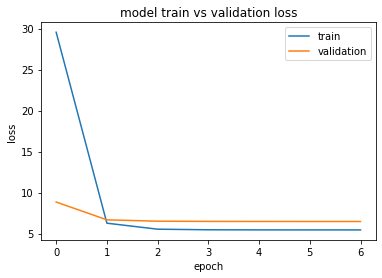

In [1920]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model train vs validation loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper right")
plt.show()

In [1863]:
from keras.models import load_model

In [1864]:
result_training = model.evaluate(input_seqs_test_, target_out_test_)

157/157 [==============================] - 20s 124ms/step - loss: 6.5369


In [1865]:
predicted = model.predict(input_seqs_test_)

In [1866]:
predicted = predicted  # sc_preds.inverse_transform(predicted)
truth = target_out_test_.reshape(
    -1, 1
)  # sc_preds.inverse_transform(target_out_test_.reshape(-1, 1))

data_chart = pd.DataFrame(
    {
        "true": truth.reshape((1, -1))[0],
        "pred": predicted.reshape((1, -1))[0],
    }
)

<AxesSubplot:>

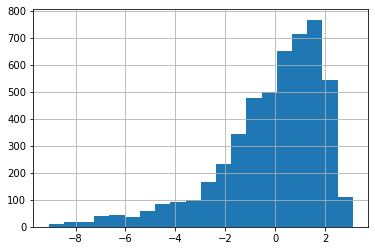

In [1867]:
data_chart.pred.hist(bins=20)

<AxesSubplot:>

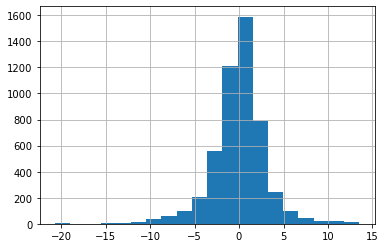

In [1868]:
data_chart.true.hist(bins=20)

In [1869]:
data_chart["times"] = time_seqs_test

In [1870]:
predVStrue_chart = alt.Chart(data_chart).mark_circle(opacity=0.5).encode(
    x="true", y="pred", tooltip="times"
) + alt.Chart(
    pd.DataFrame({"x": np.linspace(0, 15, 10), "y": np.linspace(0, 15, 10)})
).mark_line(
    color="black"
).encode(
    x="x", y="y"
)
display(predVStrue_chart)

alt.LayerChart(...)

In [1871]:
predVStruth_avgdelay_df = data_chart.merge(
    temp_df_test[["avg_delay_in30min", "avg_delay_30min", "on_runway_time"]],
    how="left",
    left_on="times",
    right_on="on_runway_time",
)

In [1872]:
predVStruth_avgdelay_df["predicted_avg_in30min"] = (
    predVStruth_avgdelay_df["avg_delay_30min"] + predVStruth_avgdelay_df["pred"]
)

In [1873]:
results(
    predVStruth_avgdelay_df.avg_delay_in30min,
    predVStruth_avgdelay_df.predicted_avg_in30min,
)

ResMetrics(mae=1.6281797051914306, mse=5.744033957054795, rmse=2.3966714328532386, acc1min=44.04952076677316, acc3min=87.02076677316293, acc5min=95.56709265175719, r2=0.1312859588718034)